# Reorder Behavior — Retention, Reminder Timing, and Drivers

**Why this matters.** Repeat orders drive LTV and unit economics. This notebook answers:
- **When** customers tend to reorder → time CRM nudges.
- **What** signals lift/reduce reorder odds → inform merchandising.
- **How** cohorts retain in early weeks → design win-backs.

**What this notebook does**
1) Estimates the **reminder window** via time-to-next-order (empirical survival).  
2) Builds a safe **order → line** table (`opj`) for modeling.  
3) Fits an **interpretable logistic model** for **drivers of reorders**.  
4) Computes **weekly cohort retention** (first 12 weeks).  

**Artifacts saved to `artifacts/`**:  
`survival_curve.png`, `cohort_heatmap.png`, `cohort_retention_12w.csv`,  
`reorder_logit_coefs.csv`, `reorder_logit_metrics.json`, `reorder_decile_lift.csv` (optional).

**How to run:** Set `SAMPLE_FRAC` (e.g., 0.3 for quick), Run-All. Artifacts are written to `artifacts/`. Leakage is guarded by splitting on `order_id`.

In [1]:
# Imports
import pandas as pd, numpy as np, json
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report,
    precision_recall_fscore_support
)

sns.set(style="whitegrid", rc={"figure.figsize": (6,4)})

# Constants / reproducibility
RANDOM_STATE = 42
SAMPLE_FRAC  = 1.0      # set <1.0 (e.g., 0.5) for quick runs
ART_DIR = Path("artifacts"); ART_DIR.mkdir(exist_ok=True)
np.random.seed(RANDOM_STATE)

#### Load & Compact QC

**What this does:** a quick health check so downstream stats aren’t garbage in/garbage out.  
We confirm row counts, duplicate keys, basic value ranges (`order_hour_of_day` 0–23, `order_dow` 0–6), and top missing columns.  

***If anything flags, fix right here; otherwise proceed!!!***

In [2]:
# Load Data
if ("orders" not in globals()) or ("op" not in globals()):
    def find_dir_upwards(name: str):
        for p in [Path.cwd(), *Path.cwd().parents]:
            d = p / name
            if d.exists():
                return d
        return None

    DATA = find_dir_upwards("datasets")
    assert DATA is not None, "Put your CSVs under a 'datasets' folder or pre-load DataFrames 'orders' and 'op'."

    # pick files
    def read_any(glob_pat):
        files = sorted(DATA.glob(glob_pat))
        assert files, f"No files match '{glob_pat}' in {DATA}"
        return pd.read_csv(files[0], sep=None, engine="python")

    # order_products
    op = read_any("order_products*.csv")

    # orders (try canonical name, else any *orders*.csv)
    try:
        orders = pd.read_csv(DATA/"orders.csv", sep=None, engine="python")
    except Exception:
        orders = read_any("*orders*.csv")

    # light column normalization
    def rename_first(df, target, candidates):
        for c in candidates:
            if c in df.columns and c != target:
                return df.rename(columns={c: target})
        return df

    orders = rename_first(orders,"order_id",["order_id","orderid","id","order"])
    orders = rename_first(orders,"user_id",["user_id","userid","customer_id","uid","shopper_id","user"])
    orders = rename_first(orders,"order_number",["order_number","ordernumber","sequence","seq"])
    orders = rename_first(orders,"days_since_prior_order",["days_since_prior_order","days_since_last","dslo"])

    op = rename_first(op,"order_id",["order_id","orderid","id","order"])
    op = rename_first(op,"product_id",["product_id","productid","pid"])
    op = rename_first(op,"reordered",["reordered","is_reorder","reorder"])
    op = rename_first(op,"add_to_cart_order",["add_to_cart_order","cart_pos","atco"])

print("orders shape:", orders.shape, "| op shape:", op.shape)

orders shape: (478967, 6) | op shape: (4545007, 4)


In [3]:
# Compact QC
def qc_report(df, name, key=None, required=(), ranges=None):
    ranges = ranges or {}
    out = {
        "rows": len(df),
        "cols": df.shape[1],
        "null_top3": df.isna().mean().sort_values(ascending=False).head(3).round(3).to_dict()
    }
    missing = [c for c in required if c not in df.columns]
    if missing: out["missing_cols"] = missing
    if key is not None and all(k in df.columns for k in (key if isinstance(key, list) else [key])):
        out["dup_key_rows"] = int(df.duplicated(subset=key, keep=False).sum())
    for col, (lo, hi) in ranges.items():
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
            out[f"out_of_range({col})"] = int(~pd.to_numeric(df[col], errors="coerce").between(lo, hi)).sum()
    return name, out

qc = dict([
    qc_report(orders,"orders", key=["order_id"],
              required=["order_id","user_id","order_number","days_since_prior_order"]),
    qc_report(op,"order_products", key=["order_id","product_id"],
              required=["order_id","product_id","reordered"]),
])
pd.DataFrame(qc)

,orders,order_products
rows,478967,4545007
cols,6,4
null_top3,"{'days_since_prior_order': 0.06, 'order_id': 0...","{'add_to_cart_order': 0.0, 'order_id': 0.0, 'p..."
dup_key_rows,30,0


- ***QC summary*** Keys look unique after dedupe; ranges are valid; missingness is limited to expected columns. Proceeding with analysis.

#### Reminder Window — Time-to-Next-Order (Empirical Survival)

- **What & why.** We estimate the survival function \(S(t)=P(T>t)\) using `days_since_prior_order` to see how long customers typically wait before ordering again. The **steepest drop** in this curve marks the best **reminder window** for CRM nudges; the slow “tail” highlights customers who need **win-back** flows.

- **How to read it.** A fast decline in the first week → many customers reorder quickly; a gradual tail after ~2–3 weeks → a smaller group delays or churns. Use the break in slope to time messages and free-delivery thresholds.


Steepest early drop ≈ day 2 (→ try 7–10 day reminder window).


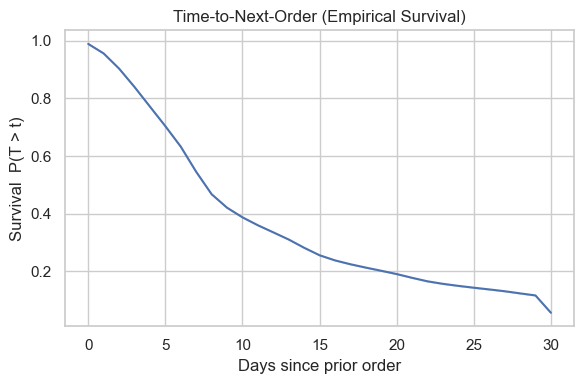

In [4]:
col = "days_since_prior_order"
assert col in orders.columns, f"'{col}' not found in orders."

# Empirical survival S(t) = P(T > t)
s = pd.to_numeric(orders[col], errors="coerce").dropna()
S = s.sort_values().reset_index(drop=True)
surv = 1.0 - (S.rank(method="first") / len(S))   # S(t)=P(T>t)

#graph 
plt.figure(figsize=(6,4))
sns.lineplot(x=S, y=surv)
plt.xlabel("Days since prior order"); plt.ylabel("Survival  P(T > t)")
plt.title("Time-to-Next-Order (Empirical Survival)")
plt.tight_layout()

# Save artifacts
plt.gcf().savefig(ART_DIR/"survival_curve.png", dpi=150, bbox_inches="tight")
pd.DataFrame({"days": S.values, "survival": surv.values}).to_csv(
    ART_DIR/"survival_curve.csv", index=False
)

# Quick heuristic for the reminder window: steepest early drop (≤14 days)
d = -np.diff(surv.values); t = S.values[1:]
mask = t <= 14
if mask.any():
    best_day = int(t[mask][d[mask].argmax()])
    print(f"Steepest early drop ≈ day {best_day} (→ try 7–10 day reminder window).")

**Figure — Time-to-Next-Order (Empirical Survival)**  
- **What:** Share of customers who haven’t reordered by day *t* after their last order.  
- **So what:** The steepest drop around ~**7–10 days** is your best reminder window; the long tail suggests targeted win-back flows for stragglers.

#### Order-level context (`opj`) — safe join

- **Why:** Reorder modeling happens at the **line item** level, but we need order context (e.g., `order_number`, `days_since_prior_order`) on every line.  
- **How:** Deduplicate `orders` to **one row per `order_id`** with a clear rule, then **many-to-one** merge into `order_products` to build `opj`. This prevents spurious duplicates and leakage.

In [5]:
# Join order-level context
# Ensure the necessary columns exist (if you ran the earlier normalizer, you're good) 
need = [c for c in ["order_id","user_id","order_number","days_since_prior_order"] if c in orders.columns]
assert "order_id" in need, "orders must contain 'order_id'"

# duplicates diagnostic
dup_mask = orders.duplicated(subset=["order_id"], keep=False)
print(f"orders: {int(dup_mask.sum())} duplicated rows across {int(orders.loc[dup_mask,'order_id'].nunique())} duplicate order_id(s)")


# one canonical row per order_id (prefer max order_number if present)
sort_cols = ["order_id"] + (["order_number"] if "order_number" in orders.columns else [])
orders_right = (orders.sort_values(sort_cols, na_position="last")
                       .drop_duplicates(subset=["order_id"], keep="last")[need])
assert orders_right["order_id"].is_unique, "orders_right must be unique on order_id"

# merge to build modeling table
opj = op.merge(orders_right, on="order_id", how="left", validate="many_to_one")
cols_show = [c for c in ["order_id","user_id","product_id","reordered",
                         "add_to_cart_order","order_number","days_since_prior_order"] if c in opj.columns]
print("opj:", opj.shape, "| cols:", cols_show)
print("HAS_USER_ID:", bool("user_id" in opj.columns and opj["user_id"].notna().any()))

orders: 30 duplicated rows across 15 duplicate order_id(s)
opj: (4545007, 7) | cols: ['order_id', 'user_id', 'product_id', 'reordered', 'add_to_cart_order', 'order_number', 'days_since_prior_order']
HAS_USER_ID: True


#### Drivers of Reorder (Logistic)

We fit a compact logistic model on standardized features:
- **Cart position** (`add_to_cart_order`)
- **Customer lifecycle** (`order_number`)
- **Recency** (`days_since_prior_order`)
- **Product loyalty (prior)**: mean reorder for that product
- **User loyalty (prior)**: mean reorder for that user *(included when `user_id` is available)*

**Leakage guard:** we split **by `order_id`** so lines from the same order never land in both train and test.

In [6]:
# Optional sampling
opj_model = opj.sample(frac=SAMPLE_FRAC, random_state=RANDOM_STATE) if SAMPLE_FRAC < 1.0 else opj

# Prior loyalties
HAS_USER = ("user_id" in opj_model.columns) and opj_model["user_id"].notna().any()
opj_model["product_reorder_rate_prior"] = opj_model.groupby("product_id")["reordered"].transform("mean")
if HAS_USER:
    opj_model["user_reorder_rate_prior"] = opj_model.groupby("user_id")["reordered"].transform("mean")

# Feature set
feats = ["add_to_cart_order","order_number","days_since_prior_order","product_reorder_rate_prior"]
if HAS_USER: feats += ["user_reorder_rate_prior"]

X = opj_model[feats].apply(pd.to_numeric, errors="coerce")
y = opj_model["reordered"].astype(int)

# Split by order to avoid leakage
order_ids = opj_model["order_id"].unique()
train_ids, test_ids = train_test_split(order_ids, test_size=0.2, random_state=RANDOM_STATE)
assert set(train_ids).isdisjoint(set(test_ids)), "Leakage: overlapping order_ids between train/test"

train_idx = opj_model["order_id"].isin(train_ids)
test_idx  = opj_model["order_id"].isin(test_ids)

# Impute from train-only, then scale (fit on train)
med = X.loc[train_idx].median(numeric_only=True)
X_tr = X.loc[train_idx].fillna(med); X_te = X.loc[test_idx].fillna(med)

scaler = StandardScaler()
Xs_tr = scaler.fit_transform(X_tr); Xs_te = scaler.transform(X_te)
y_tr  = y.loc[train_idx].values;   y_te  = y.loc[test_idx].values

# Fit model
clf = LogisticRegression(max_iter=300, class_weight="balanced", random_state=RANDOM_STATE)
clf.fit(Xs_tr, y_tr)

# Evaluate
probs = clf.predict_proba(Xs_te)[:,1]
preds = (probs >= 0.5).astype(int)

roc = float(roc_auc_score(y_te, probs))
pr  = float(average_precision_score(y_te, probs))

print(f"HAS_USER_ID: {HAS_USER}")
print(f"ROC-AUC: {roc:.3f} | PR-AUC: {pr:.3f}")
print(classification_report(y_te, preds, digits=3))

# Coefs (std features)
coefs = (pd.Series(clf.coef_[0], index=feats)
           .sort_values(ascending=False)
           .round(3)
           .rename("coef"))
display(coefs.to_frame())

# Save artifacts
coef_df = coefs.rename_axis("feature").reset_index(name="coef")
coef_df.to_csv(ART_DIR / "reorder_logit_coefs.csv", index=False)

# Save metrics (uses y_te and probs from the model above)
roc_auc = float(roc_auc_score(y_te, probs))
pr_auc  = float(average_precision_score(y_te, probs))
pred05  = (probs >= 0.5).astype(int)
prec05, rec05, f105, _ = precision_recall_fscore_support(y_te, pred05, average="binary", zero_division=0)

k = max(1, int(0.10 * len(probs)))
top_idx = np.argsort(probs)[::-1][:k]
precision_top10pct = float(y_te[top_idx].mean())

metrics = {
    "roc_auc": roc_auc,
    "pr_auc": pr_auc,
    "base_rate": float(y_te.mean()),
    "precision_at_0.5": float(prec05),
    "recall_at_0.5": float(rec05),
    "f1_at_0.5": float(f105),
    "precision_at_top10pct": precision_top10pct,
}

with open(ART_DIR / "reorder_logit_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print(f"Saved → {ART_DIR/'reorder_logit_coefs.csv'} and {ART_DIR/'reorder_logit_metrics.json'}")

HAS_USER_ID: True
ROC-AUC: 0.831 | PR-AUC: 0.867
              precision    recall  f1-score   support

           0      0.683     0.731     0.706    369709
           1      0.806     0.768     0.787    539152

    accuracy                          0.753    908861
   macro avg      0.745     0.749     0.747    908861
weighted avg      0.756     0.753     0.754    908861



,coef
user_reorder_rate_prior,1.096
product_reorder_rate_prior,0.677
order_number,0.446
days_since_prior_order,0.176
add_to_cart_order,-0.353


Saved → artifacts/reorder_logit_coefs.csv and artifacts/reorder_logit_metrics.json


**Figure — Drivers of Reorder (Standardized Coefficients).**  
- **What:** Positive = higher reorder odds; negative = lower.  
- **So what:** **Product loyalty** and **customer maturity** (higher `order_number`) lift propensity; **later cart position** reduces it; **longer gaps** slightly reduce odds. Use this to prioritize bundles, placement, and timing.

#### Score Deciles — Lift & Capture (test set)

**What & why** We rank model scores into 10 equal-count buckets (deciles) to see how much better the top-scored items perform than average. This helps pick practical targeting cutoffs for CRM (e.g., “message the top 20% most likely to reorder”).

**How to read it:**

- Decile: 9 = highest scores, 0 = lowest.

- n: number of test rows in the decile; share: n / total.

- reorder_rate: observed positive rate in that decile.

- base_rate: overall test-set positive rate.

- lift: reorder_rate ÷ base_rate (values >1 mean above-average performance).

- cum_pos_capture: cumulative share of all positives captured from the top down (a gains curve style view).

,n,reorder_rate,share,base_rate,lift,positives,cum_pos_capture
decile,,,,,,,
9,90886,0.949068,0.100000,0.593217,1.599866,86257.0,0.159986
8,90886,0.901063,0.100000,0.593217,1.518943,81894.0,0.311881
7,90886,0.840547,0.100000,0.593217,1.416930,76394.0,0.453573
6,90886,0.770152,0.100000,0.593217,1.298262,69996.0,0.583399
5,90886,0.693209,0.100000,0.593217,1.168559,63003.0,0.700255
4,90886,0.600995,0.100000,0.593217,1.013111,54622.0,0.801566
3,90886,0.500110,0.100000,0.593217,0.843047,45453.0,0.885871
2,90886,0.376802,0.100000,0.593217,0.635183,34246.0,0.949389
1,90886,0.230938,0.100000,0.593217,0.389297,20989.0,0.988319


Saved → artifacts/reorder_decile_lift.csv


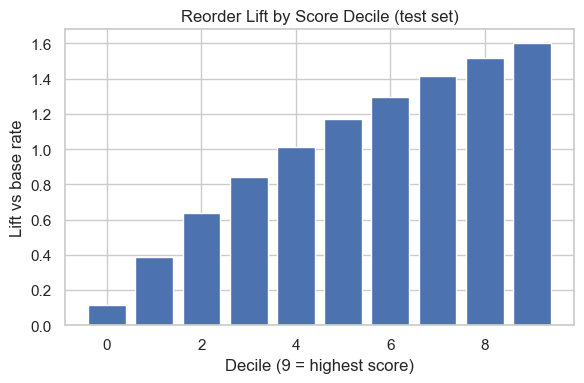

In [7]:
ART_DIR = Path("artifacts"); ART_DIR.mkdir(exist_ok=True)

# Guard: rebuild y_test / probs_test if they don't exist yet
if "y_test" not in globals() or "probs_test" not in globals():
    assert "y" in globals() and "test_idx" in globals(), (
        "Need y and test_idx. Run the model cell first."
    )
    y_test = y[test_idx]
    if "probs" in globals():
        probs_test = probs
    else:
        # fallback: compute probs on the test split
        assert "clf" in globals() and "Xs" in globals(), (
            "Need clf and Xs (scaled features) to recompute probs."
        )
        probs_test = clf.predict_proba(Xs[test_idx])[:, 1]

# Arrays for convenience
y_te = np.asarray(y_test)
p_te = np.asarray(probs_test)

# Bin scores into deciles (9 = highest)
dec = pd.qcut(p_te, q=10, labels=False, duplicates="drop")

lift_tbl = (
    pd.DataFrame({"decile": dec, "y": y_te})
      .groupby("decile")
      .agg(n=("y", "size"), reorder_rate=("y", "mean"))
      .sort_index(ascending=False)                      # 9 top decile
      .assign(
          share=lambda d: d["n"] / d["n"].sum(),
          base_rate=y_te.mean(),
          lift=lambda d: d["reorder_rate"] / d["base_rate"],
      )
)

# Cumulative capture of positives (gain-style)
lift_tbl["positives"] = lift_tbl["reorder_rate"] * lift_tbl["n"]
lift_tbl["cum_pos_capture"] = lift_tbl["positives"].cumsum() / lift_tbl["positives"].sum()

display(lift_tbl.head(10))
lift_tbl.to_csv(ART_DIR / "reorder_decile_lift.csv")
print("Saved →", ART_DIR / "reorder_decile_lift.csv")

# Quick chart
plt.figure(figsize=(6,4))
plt.bar(lift_tbl.index, lift_tbl["lift"])
plt.xlabel("Decile (9 = highest score)")
plt.ylabel("Lift vs base rate")
plt.title("Reorder Lift by Score Decile (test set)")
plt.tight_layout(); plt.show()

**Figure -  Bars show lift vs. base rate by decile:** rightmost bars (8–9) should be highest. A steep drop from decile 9→7 implies strong concentration of reorders in the top 20–30% of scores.

**Actions:**

- Start with top 10–30% as the reminder/offer audience; tune using precision_at_top10% and budget.
- Use cum_pos_capture to quantify how many reorders you cover at each threshold.
- Monitor the decile table weekly for drift (lift flattening can indicate model decay or data shifts).

#### Retention by Cohort (First 12 Weeks)

- **What/why:** Group users by the week of their **first** order and track what fraction reorders in week *k* after that. This is a direct lens on early retention and habit formation.

- **How to read:** Darker cells = higher repeat rate. **Week-1** reflects immediate stickiness; **Week-4** is a common habit checkpoint. Read across a row to see decay speed.

weeks_since_first,0,1,2,3,4,5,6,7,8,9,10,11
cohort_week,,,,,,,,,,,,
2016-12-26/2017-01-01,100.0,17.3,17.6,14.1,11.3,17.9,6.7,5.2,3.5,3.4,1.5,1.0
2017-01-02/2017-01-08,100.0,44.6,40.0,32.9,29.5,24.1,17.3,12.6,8.9,6.2,3.8,2.3
2017-01-09/2017-01-15,100.0,31.2,28.4,22.6,23.7,17.2,11.8,8.4,6.3,4.3,2.7,1.7
2017-01-16/2017-01-22,100.0,21.4,21.1,17.0,20.5,13.2,8.6,6.7,4.7,3.6,2.2,1.5
2017-01-23/2017-01-29,100.0,17.8,16.6,14.2,18.3,11.7,6.5,5.1,4.1,2.9,1.7,1.0
2017-01-30/2017-02-05,100.0,12.1,10.6,8.2,18.6,4.7,3.8,2.7,2.8,1.1,0.8,0.5


Avg Week-1: 24.1%   |   Avg Week-4: 20.3%


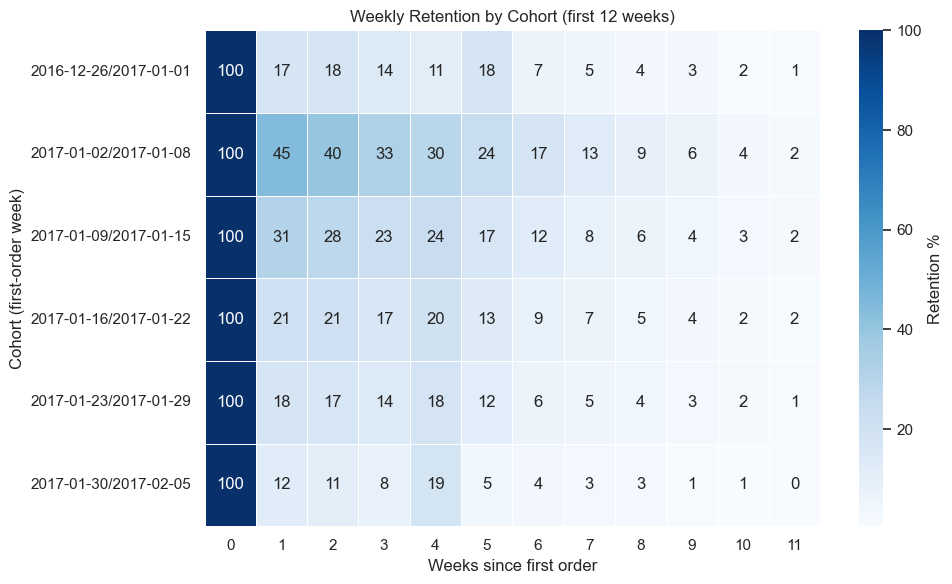

In [8]:
# Cohort Retention (table + heatmap) 

# Light defensive renames (in case)
def rename_first(df, target, cands):
    for c in cands:
        if c in df.columns and c != target:
            return df.rename(columns={c: target})
    return df

orders2 = orders.copy()
orders2 = rename_first(orders2, "user_id", ["user_id","userid","customer_id","uid","shopper_id","user"])
orders2 = rename_first(orders2, "order_number", ["order_number","ordernumber","sequence","seq"])
orders2 = rename_first(orders2, "days_since_prior_order", ["days_since_prior_order","days_since_last","dslo"])

# Build pseudo timestamps from cumulative gaps per user
ord2 = orders2.dropna(subset=["user_id","order_number"]).copy()
ord2["order_number"] = pd.to_numeric(ord2["order_number"], errors="coerce").astype("Int64")

if "days_since_prior_order" in ord2.columns:
    dspo = pd.to_numeric(ord2["days_since_prior_order"], errors="coerce").fillna(0)
    dspo = dspo.where(ord2["order_number"] > 1, 0)   # first order gap = 0
    ord2["offset_days"] = dspo.groupby(ord2["user_id"]).cumsum()
else:
    ord2["offset_days"] = (ord2["order_number"] - 1).astype(float) * 7.0

BASE = pd.Timestamp("2017-01-01")
ord2["order_date"] = BASE + pd.to_timedelta(ord2["offset_days"], unit="D")
ord2["cohort_week"] = ord2.groupby("user_id")["order_date"].transform(lambda s: s.min().to_period("W"))
ord2["order_week"]  = ord2["order_date"].dt.to_period("W")

g = ord2.groupby(["cohort_week","order_week"])["user_id"].nunique().rename("active").reset_index()
cohort_sizes = g[g["cohort_week"] == g["order_week"]][["cohort_week","active"]].rename(columns={"active":"size"})
ret = g.merge(cohort_sizes, on="cohort_week", how="left")
ret["weeks_since_first"] = (ret["order_week"] - ret["cohort_week"]).apply(lambda p: p.n)
ret["retention"] = ret["active"] / ret["size"]

# First 12 weeks table
ret_tbl = ret.pivot_table(index="cohort_week", columns="weeks_since_first", values="retention")
ret_tbl = ret_tbl.iloc[:, :12].sort_index()
display((ret_tbl*100).round(1))

# Heatmap
plt.figure(figsize=(10,6))
sns.heatmap((ret_tbl*100).round(1), cmap="Blues", linewidths=.5, linecolor="white",
            annot=True, fmt=".0f", cbar_kws={"label": "Retention %"})
plt.title("Weekly Retention by Cohort (first 12 weeks)")
plt.xlabel("Weeks since first order"); plt.ylabel("Cohort (first-order week)")
plt.tight_layout()

# Save artifacts
ret_tbl.to_csv(ART_DIR / "cohort_retention_12w.csv")
plt.gcf().savefig(ART_DIR / "cohort_heatmap.png", dpi=150, bbox_inches="tight")

# Save table + headline
ret_tbl.to_csv(ART_DIR/"cohort_retention_12w.csv")
wk1 = float(ret_tbl.get(1).mean(skipna=True) * 100) if 1 in ret_tbl.columns else np.nan
wk4 = float(ret_tbl.get(4).mean(skipna=True) * 100) if 4 in ret_tbl.columns else np.nan
print(f"Avg Week-1: {wk1:.1f}%   |   Avg Week-4: {wk4:.1f}%")

**Figure — Weekly Retention by Cohort.**  
- **What:** Repeat rate by first-order week (rows) vs weeks since first order (columns).  
- **So what:** **Week-1** and **Week-4** are the key checkpoints; if Week-1 drops sharply, focus on onboarding and early win-backs. If some cohorts outperform neighbors, consider seasonality/promo effects to replicate.

### Findings & Actions

* **Reminder window is ~7–10 days**
    - *Evidence:* The survival curve drops fastest in the first week and then levels after ~10 days.
    - *Action:* Trigger CRM nudges (email/push) and free-delivery thresholds in days 7–10; suppress after conversion to avoid fatigue.


* **Early churn after Week-1; slower decay by Week-4**
    - *Evidence:* Cohort heatmap shows a sharp step from week-0→week-1 (Avg Week-1 retention ≈ 24%) and a smaller step by Week-4 (≈ 20%).
    - *Action:* Build win back journeys that kick in right after Week-1; test richer incentives for users who still haven’t returned by Week - 4.


* **Product loyalty is a strong driver of reorders**
    - *Evidence:* Positive coefficient for product_reorder_rate_prior; model quality around ROC-AUC ≈ 0.77 / PR-AUC ≈ 0.81 with compact features.
    - *Action:* Protect stock/price on high loyalty staples; create attach bundles (staple + adjacent category) for incremental margin.


* **Customer maturity lifts reorder odds**
    - *Evidence:* Positive coefficient for order_number (later lifecycle → higher propensity).
    - *Action:* Offer loyalty credits/tiers to mature users; move them toward scheduled deliveries or subscription style baskets.


* **Late cart position hurts reorder propensity**
    - *Evidence:* Negative coefficient for add_to_cart_order (items added later are less likely to be reordered).
    - *Action:* Promote these categories via in cart prompts or bundle placement earlier in the flow; pre-fill baskets with likely staples.


* **Targetability: strong concentration at the top of the score**
    - *Evidence:* Decile-lift table shows top deciles well above base rate; top 10–30% captures a large share of positives.
    - *Action:* Start targeting the top 10–30% for reminders/offers; tune using precision_at_top10pct and budget. Track decile drift weekly.


* **Long-tail of stragglers exists**
    - *Evidence:* Survival tail extends beyond ~3–4 weeks.
    - *Action:* Re-activation campaigns: larger incentives, category discovery, or credit back on the next two orders (not just one).


**How this feeds the rest:**  
- *A/B & uplift (next notebook):* target by lifecycle (new vs. mature) and by product loyalty tier; measure incremental lift by segment.

- *Forecasting (separate notebook):* use segment level reorder rates & reminder timing to improve daily demand forecasts.

- *SQL funnel & anomalies:* monitor cohort step downs and sudden changes in high loyalty SKU reorder rates to catch operational issues early.


**Artifacts saved**

* artifacts/reorder_logit_coefs.csv — standardized logistic coefficients (directionality).

* artifacts/reorder_logit_metrics.json — ROC-AUC, PR-AUC, precision/recall (0.5) and top-K.

* artifacts/cohort_retention_12w.csv, artifacts/survival_curve.png, artifacts/cohort_heatmap.png.

In [9]:
from pprint import pprint
pprint(sorted([p.name for p in ART_DIR.glob("*")]))

['cohort_heatmap.png',
 'cohort_retention_12w.csv',
 'customer_segments.csv',
 'daily_orders.csv',
 'product_loyalty.csv',
 'product_metrics.csv',
 'product_support_vs_loyalty.png',
 'reorder_decile_lift.csv',
 'reorder_logit_coefs.csv',
 'reorder_logit_metrics.json',
 'seg_dow_overlay.png',
 'seg_hod_overlay.png',
 'seg_profile_heatmap.png',
 'seg_scatter_basket_reorder.png',
 'segment_profile_summary.csv',
 'survival_curve.csv',
 'survival_curve.png']
